In [2]:
import time
import numpy as np
from scipy.spatial import distance

#topological data analysis
from ripser import ripser
from persim import plot_diagrams

#plotting and visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.patches import Circle

import matplotlib.pyplot as plt
%matplotlib inline

import math
import cmath

import random
# import numpy as np

#manifold learning and dim red
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding as LLE

#topological data analysis
from dreimac import CircularCoords, CircleMapUtils, ToroidalCoords, GeometryUtils

#plotting and visualization
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output, no_update
import plotly.graph_objects as go
import pandas as pd
import base64

from matplotlib import cm
# import matplotlib.pyplot as plt
# %matplotlib inline


def plot_barcodes(diagrams, alpha_max, width = 1.5):
    max_dim = len(diagrams)
    fig, axs = plt.subplots(max_dim)
    fig.suptitle('Barcodes')
    for dim in range(max_dim):
        barcode = np.copy(diagrams[dim])
        ind_inf = np.isinf(barcode.T[1])
        barcode[ind_inf, 1] = alpha_max
        h = 1
        for i in range(len(barcode)):
            x = barcode[i]
            y = [h,h]
            axs[dim].plot(x, y, linestyle= '-', c='#1f77b4', linewidth = width)
            if ind_inf[i]:
                axs[dim].scatter([alpha_max],[h],  s=10, marker='>', c='#1f77b4')
            h += 1
        axs[dim].set_xlim(0, 1.05*alpha_max)
        axs[dim].set_ylim(0,h)
        axs[dim].get_yaxis().set_ticks([]);
        axs[dim].spines['right'].set_color('none')
        axs[dim].spines['top'].set_color('none')
        axs[dim].text(0.3,1,'$\mathrm{bcd}^{\mathcal{R}}_{'+str(dim)+'}(X)$', verticalalignment='bottom')

In [3]:
penta2 = np.loadtxt('../data/G2.txt', delimiter=',')

print(penta2.shape)

(59871, 10)


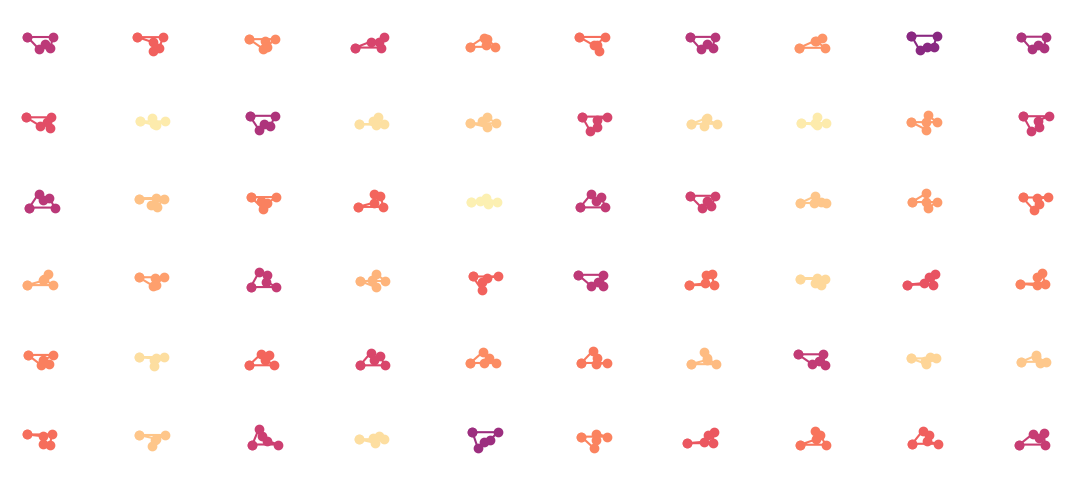

In [4]:
angle_data = np.zeros((penta2.shape[0],5)) # internal angles

for i in range(5):
    ii = (2*i -2)%10
    jj = (2*i - 1)%10
    u = penta2[:, [ii, jj]]
    
    ii = (2*i)%10
    jj = (2*i + 1)%10
    v = penta2[:, [ii , jj]]
    
    ii = (2*i + 2)%10
    jj = (2*i + 3)%10
    w = penta2[:, [ii, jj]]
    
    z = np.sum((u - v)*(w-v), axis = 1)
    
    angle_data[:,i]  = np.arccos( np.minimum(z,1) )
    
energy = np.sum((angle_data - (3/5)*np.pi)**2 , axis = 1)

# plot sample pentagons
plt.figure(figsize=(14,6))
for i in range(60):
    ind = random.randint(0, penta2.shape[0])
    x = penta2[ind].reshape(5,2).T
    cent = np.mean(x,axis=1)
    plt.subplot(6,10,i+1)
    plt.plot(x[0,range(-1,5)], x[1,range(-1,5)] , '-o', c= cm.magma(energy[ind]/np.max(energy)))
    plt.axis('square')
    plt.axis('off')
    plt.xlim(cent[0]-1.3,cent[0]+1.3);
    plt.ylim(cent[1]-1.3,cent[1]+1.3);

In [ ]:
n_land = 900
res = ripser(penta2, n_perm = n_land, maxdim=2, coeff =13, thresh = 1.8)
dgms = res['dgms']
plt.figure(figsize = (4,4))
plot_diagrams(dgms)

In [ ]:
pers1 = dgms[1][:,1] - dgms[1][:,0]
pers2 = dgms[2][:,1] - dgms[2][:,0]

pers1_sorted = np.sort(pers1)[::-1]
pers2_sorted = np.sort(pers2[pers2 < np.Inf])[::-1]

print('Persistence of top 10 1-d features:\n', np.around(pers1_sorted[0:10],decimals=2), '\n')
print('Persistence of top 10 2-d features:\n', np.around(pers2_sorted[0:10],decimals=2))

In [5]:
# n_land = 3000
# k_neigh = 15
n_land = 1200
k_neigh = 35
dist_mat, pointcloud_permutation = GeometryUtils.landmark_geodesic_distance(penta2, n_land, k_neigh)

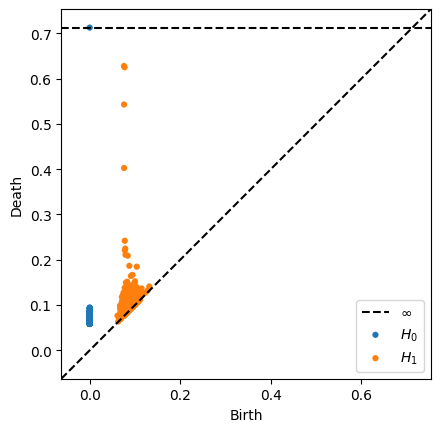

In [6]:
cc = CircularCoords(dist_mat , n_landmarks= n_land, distance_matrix=True)
#cc = CircularCoords(penta2 , n_landmarks= 3000)

plot_diagrams(cc.dgms_)

In [7]:
pers1 = cc.dgms_[1][:,1] - cc.dgms_[1][:,0]

pers1_sorted = np.sort(pers1)[::-1]

print('Persistence of top 10 1-d features:\n', np.around(pers1_sorted[0:10],decimals=2), '\n')

Persistence of top 10 1-d features:
 [0.55 0.55 0.47 0.33 0.16 0.15 0.14 0.13 0.12 0.1 ] 



In [8]:
coho_classes = [1, 2, 3, 4]

circular_coords = []

for i in coho_classes:
    circular_coords.append(cc.get_coordinates(perc = 0.6, cocycle_idx=i, standard_range= False))

In [17]:
thetas= CircleMapUtils.linear_combination(np.array(circular_coords), [[1,0,0,0], [0,1,0,0],[0,0,1,0], [0,0,0,1]])

theta1 = CircleMapUtils.center(thetas[0])
theta2 = CircleMapUtils.center(thetas[1])
theta3 = CircleMapUtils.center(thetas[2])
theta4 = CircleMapUtils.center(thetas[3])


fig = go.Figure(data=[go.Scatter3d(
    x=theta1, y=theta2, z=theta3, 
    mode ='markers', 
    marker=dict(size = 3, color =energy[pointcloud_permutation], colorscale='plasma')
)])

fig.update_layout(autosize=False, width=700, height=700)

fig.show(renderer='chrome')

#genus 2 surface sample 3000 [[1,0,0,0], [0,1,0,0],[0,0,-1,0], [0,0,0,1]] 1,2,3 works

In [26]:
spots=[]
reversey=penta2[pointcloud_permutation]
permuted_energy=energy[pointcloud_permutation]
for num in range(len(penta2)):
    if 0<theta2[num]<1.5:
        spots.append(num)
spots=np.array(spots)
section = reversey[spots]
print(section)

[[ 1.          0.          0.56245978 ... -0.21205509  0.
   0.        ]
 [ 1.          0.          0.67862976 ... -0.11668521  0.
   0.        ]
 [ 1.          0.          0.57270079 ...  0.07765689  0.
   0.        ]
 ...
 [ 1.          0.          0.73507473 ... -0.17275386  0.
   0.        ]
 [ 1.          0.          0.73507473 ...  0.11306603  0.
   0.        ]
 [ 1.          0.          0.73507473 ... -0.11306603  0.
   0.        ]]


In [28]:
fig = go.Figure(data=[go.Scatter3d(
    x=theta1[spots], y=theta2[spots], z=theta3[spots], 
    mode ='markers', 
    marker=dict(size = 3, color =permuted_energy[spots], colorscale='plasma')
)])

fig.update_layout(autosize=False, width=700, height=700)

fig.show(renderer='chrome')

In [23]:
#PCA
pca = PCA(n_components=5)
data_pca = pca.fit(section).transform(section)

print('Explained Variance', pca.explained_variance_ratio_)

fig = go.Figure(data=[go.Scatter3d(
    x=data_pca[:,0], y=data_pca[:,1], z=data_pca[:,2], 
    mode ='markers',
    marker=dict(size = 3, color = permuted_energy[spots], colorscale='plasma' , opacity = 1)
)])

fig.update_layout(autosize=False, width=700, height=700)  

fig.show(renderer='chrome')

Explained Variance [0.71638131 0.21184607 0.03376341 0.02839322 0.00826935]


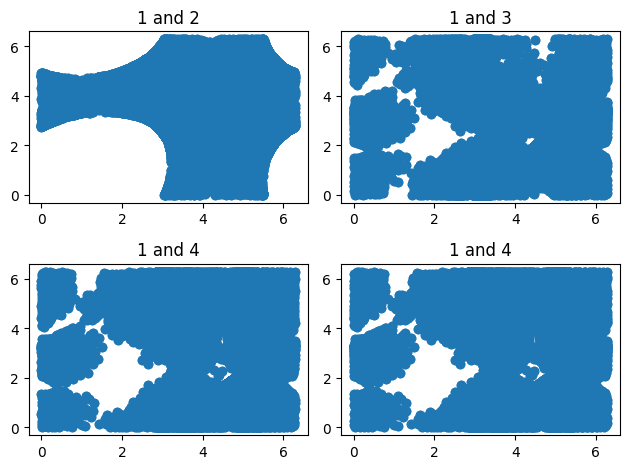

In [49]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)
  
# For 1 and 2 Function
axis[0, 0].scatter(theta1, theta2)
axis[0, 0].set_title("1 and 2")
  
# For 1 and 3 Function
axis[0, 1].scatter(theta1, theta3)
axis[0, 1].set_title("1 and 3")
  
# For 1 and 4 Function
axis[1, 0].scatter(theta1, theta4)
axis[1, 0].set_title("1 and 4")
  
# For 1 and 5 Function
axis[1, 1].scatter(theta1, theta4)
axis[1, 1].set_title("1 and 4")
  
# Combine all the operations and display
figure.tight_layout()
plt.show()

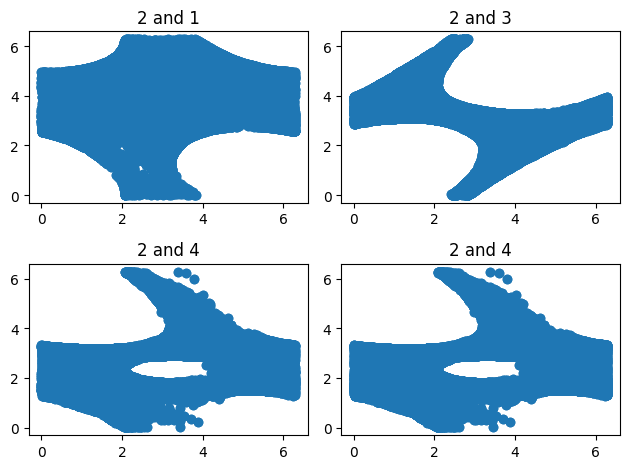

In [39]:
figure, axis = plt.subplots(2, 2)
  
# For 2 and 1 Function
axis[0, 0].scatter(theta2, theta1)
axis[0, 0].set_title("2 and 1")
  
# For 2 and 3 Function
axis[0, 1].scatter(theta2, theta3)
axis[0, 1].set_title("2 and 3")
  
# For 2 and 4 Function
axis[1, 0].scatter(theta2, theta4)
axis[1, 0].set_title("2 and 4")
  
# For 2 and 5 Function
axis[1, 1].scatter(theta2, theta4)
axis[1, 1].set_title("2 and 4")
  
# Combine all the operations and display
figure.tight_layout()
plt.show()

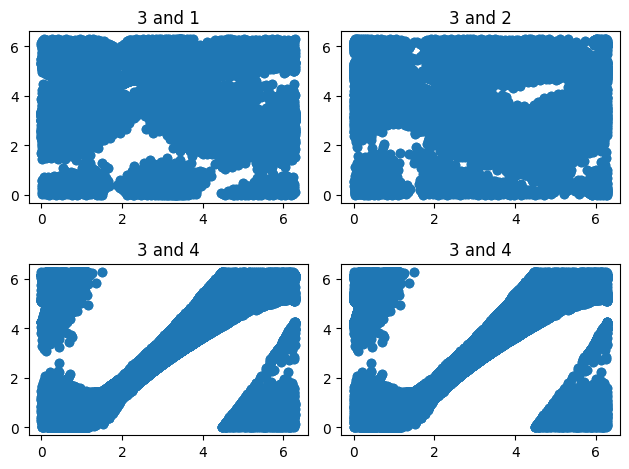

In [50]:
figure, axis = plt.subplots(2, 2)
  
# For 2 and 1 Function
axis[0, 0].scatter(theta3, theta1)
axis[0, 0].set_title("3 and 1")
  
# For 2 and 3 Function
axis[0, 1].scatter(theta3, theta2)
axis[0, 1].set_title("3 and 2")
  
# For 2 and 4 Function
axis[1, 0].scatter(theta3, theta4)
axis[1, 0].set_title("3 and 4")
  
# For 2 and 5 Function
axis[1, 1].scatter(theta3, theta4)
axis[1, 1].set_title("3 and 4")
  
# Combine all the operations and display
figure.tight_layout()
plt.show()

In [ ]:
tc = ToroidalCoords(penta2, n_landmarks=3000)
plot_diagrams(tc.dgms_)

In [ ]:
cohomology_classes = [0, 1, 2, 3]
toroidal_coords = tc.get_coordinates(cocycle_idxs=cohomology_classes)
toroidal_coords = CircleMapUtils.linear_combination(np.array(circular_coords), [[1,0,0,0], [0,1,0,0],[0,0,-1,0], [0,0,0,1]])
t1=CircleMapUtils.center(toroidal_coords[0])
t2=CircleMapUtils.center(toroidal_coords[1])
t3=CircleMapUtils.center(toroidal_coords[2])
t4=CircleMapUtils.center(toroidal_coords[3])

fig = go.Figure(data=[go.Scatter3d(
    x=t1, y=t2, z=t3, 
    mode ='markers', 
    marker=dict(size = 3, color =energy, colorscale='plasma')
)])

fig.update_layout(autosize=False, width=700, height=700)

fig.show(renderer='chrome')

In [ ]:
n_lands=1000
n_neigh = 15

coho_data = np.array([t1, t2, t3]).T

dist_mat, pc_perm = GeometryUtils.landmark_geodesic_distance(coho_data, n_lands, n_neigh)

coho = CircularCoords(dist_mat, distance_matrix=True , n_landmarks= n_lands)

In [ ]:
coho_classes_p = [0, 1, 3, 4, 5, 6, 7, 8]

circular_coords_coho = []

for i in coho_classes_p:
    circular_coords_coho.append(coho.get_coordinates(perc = 0.6, cocycle_idx=i, standard_range= False))

In [ ]:
fig = go.Figure(data=[go.Scatter3d(
    x=t1[pc_perm], y=t2[pc_perm], z=t3[pc_perm], 
    mode ='markers', 
    marker=dict(size = 3, color =circular_coords_coho[0], colorscale='plasma')
)])

fig.update_layout(autosize=False, width=700, height=700)

fig.show(renderer='chrome')

In [ ]:
#take in cuts as a list circular coordinate arrays
from sklearn.neighbors import NearestNeighbors

cuts=[circular_coords_coho[0]]

#calculate the k nearest neighbors graph

n_land = 900
k_neigh = 25
nbrs = NearestNeighbors(n_neighbors=k_neigh, algorithm='ball_tree').fit(coho_data)
distances, indices = nbrs.kneighbors(coho_data)

#the output is a list of pairs of ndarrays that has length n_data. For any row (each representing a point),
#the first element of the pair is the indices in the data for the k nearest points
#and the second element is the distance between each point and the current row (point).
simplicial_complex=[[indices[i],distances[i]] for i in range(len(indices))]

In [ ]:
#this function makes cuts and takes in a list of circular coords arrays as well as a neighbor graph and outputs a cut graph
def cut_neighbors(cuts, neighbor_graph):
    removals=0
    for ind, point in enumerate(neighbor_graph):
        counts=[]
        for count, i in enumerate(point[0]):
            if any(np.abs(cut[ind]-cut[i]) > 1.8*np.pi for cut in cuts):
                counts.append(count)
                removals+=1
        neighbor_graph[ind][0]=np.delete(neighbor_graph[ind][0],counts)
        neighbor_graph[ind][1]=np.delete(neighbor_graph[ind][1],counts)
    print('Removals: ',removals)
    return neighbor_graph

new_neighbor_graph=cut_neighbors(cuts, simplicial_complex)

In [ ]:
#now we transform our cut up graph into a numpy distance matrix and then a compressed sparse matrix
#we can do this because out neighbors graph contained distance data in it

from scipy.sparse import csr_matrix

kneighbors_graph=np.zeros((penta2.shape[0],penta2.shape[0]))
for count, info in enumerate(simplicial_complex):
    for place, ind in enumerate(info[0]):
        kneighbors_graph[count,ind]=info[1][place]
kneighbors_graph=csr_matrix(kneighbors_graph)

In [ ]:
#calculating geodesic distance matrix
from scipy.sparse.csgraph import shortest_path

n_landmarks=800

n_points = coho_data.shape[0]
perm = np.zeros(n_landmarks, dtype=np.int64)
lambdas = np.zeros(n_landmarks)
ds = shortest_path(kneighbors_graph, indices=0, directed=False)
D = np.zeros((n_landmarks, n_points))
D[0, :] = ds
for i in range(1, n_landmarks):
    idx = np.argmax(ds)
    perm[i] = idx
    lambdas[i] = ds[idx]
    thisds = shortest_path(kneighbors_graph, indices=idx, directed=False)
    D[i, :] = thisds
    ds = np.minimum(ds, thisds)

perm_rest_points = np.setdiff1d(
np.arange(0, n_points, dtype=int), perm, assume_unique=True
)
perm_all_points = np.concatenate((perm, perm_rest_points))

dist_landmarks_points = D[:, perm_all_points]

In [ ]:
#check that the distance matrix has no infinity values

inf_in_mat=[]
for i in dist_landmarks_points:
    if list(np.isinf(i)).count(True)==0:
        inf_in_mat.append(True)
    else:
        inf_in_mat.append(False)
        break

print('Distance matrix has no infinity values: ',all(inf_in_mat))

In [ ]:
#using scipy to calculate the multi-dimensional scaling of the distance matrix
from sklearn import manifold

mds= manifold.MDS(
    n_components=2,
    metric=True,
    dissimilarity="precomputed",
    normalized_stress='auto'
)
unfolding = mds.fit_transform(dist_landmarks_points[:,0:dist_landmarks_points.shape[0]])

In [ ]:
# fig = go.Figure(data=[go.Scatter(
#     x=unfolding[:, 0], y=unfolding[:, 1], 
#     mode ='markers', 
#     marker=dict(size = 7, color =energy[perm], colorscale='plasma')
# )])

# fig.update_layout(autosize=False, width=1000, height=1000)

# fig.show(renderer='chrome')
fig = go.Figure(data=[go.Scatter(
    x=unfolding[:, 0], y=unfolding[:, 1], 
    mode ='markers', 
    marker=dict(size = 7, color =circular_coords_coho[0][perm_all_points], colorscale='plasma')
)])

fig.update_layout(autosize=False, width=1000, height=1000)

fig.show(renderer='chrome')